In [1]:
%load_ext autoreload
%autoreload 2

## Statement 1

The US government bond market is major debt market. Due to the rate hiking exercise from the Federal Reserve, the US government bond market becomes action filled. The US government bond instruments have a wide range of maturity, from 1 month to 30 years. 10-year US government bond yield has representational importance.

The objective is to build a monthly-frequency model to track the US government bond yield. The goodness of fit can be measured in two aspects (1) Good fit to the historical data on a suitable error measure. (2) Closely track the future market point on a suitable error measure (bonus). One can use both the time series dynamic or/and the economic factors for the model.

A dataset of bond yield of different maturities and economic factors will be provided. You may just use a subset of the data for the model building. Not all data are useful.

**We shall define the problem as forecasting average monthly DGS10 one month ahead**

In [3]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

from src.utils1 import load_yields, load_econs, evaluate

## Load and merge data

- `load_yields()`: Load and merge all sheets on yields from xlsx file. The data frequency is daily
- `load_econs()`: Load and merge sheets on economic factors (except GDP related). The data frequency is monthly. Since `Initial Claims (ICSA)` frequency is weekly, it will be resampled to monthly using averaging first.

In [4]:
yields_df = load_yields()
yields_df.tail()

DGS10 (15919, 1)
Fed Funds Effective Rate (6005, 2)
DGS1MO (5594, 3)
DGS3MO (5594, 4)
DGS6MO (5594, 5)
DGS1 (5594, 6)
DGS2 (5594, 7)
DGS3 (5594, 8)
DGS5 (5594, 9)
DGS7 (5594, 10)
DGS20 (5594, 11)
DGS30 (5594, 12)


,DGS10,DFF,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS20,DGS30
observation_date,,,,,,,,,,,,
2023-01-02,NaN,4.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,3.79,4.33,4.17,4.53,4.77,4.72,4.40,4.18,3.94,3.89,4.06,3.88
2023-01-04,3.69,4.33,4.20,4.55,4.77,4.71,4.36,4.11,3.85,3.79,3.97,3.81
2023-01-05,3.71,4.33,4.30,4.66,4.81,4.78,4.45,4.18,3.90,3.82,3.96,3.78
2023-01-06,3.55,4.33,4.32,4.67,4.79,4.71,4.24,3.96,3.69,3.63,3.84,3.67


In [10]:
yields_df.to_csv("./results/yields.csv")

In [5]:
econs_df = load_econs()
econs_df.tail()

INFO:root:Loading Initial Claims (ICSA)
INFO:root:Loading Capacity Utilization (Fred)
INFO:root:Loading Industrial Production
INFO:root:Loading CPI (Level, SA, Fred)
INFO:root:Loading PCE (Level, SA, Fred, SAAR)
INFO:root:Loading IPI (All Commods, Index, NSA)
INFO:root:Loading Total Nonfarm (Fred)
INFO:root:Loading Unemployment Rate (SA, Fred)
INFO:root:Loading Adv Retail Sales (SA, Mil)
INFO:root:final df shape: (367, 9)


,ICSA,TCU,INDPRO,CPALTT01USM661S,PCE,IR,PAYEMS,UNRATE,RSXFS
observation_date,,,,,,,,,
2022-03-01,195000.0,79.8540,103.6218,121.387074,16831.2,146.8,150856,3.6,587570
2022-04-01,178000.0,80.2525,104.3022,121.789998,16904.9,147.5,151224,3.6,590238
2022-05-01,184400.0,80.0549,104.2103,122.975989,16991.6,148.2,151610,3.6,591793
2022-06-01,207000.0,79.9401,104.2229,124.602033,17160.6,148.5,151903,3.6,598145
2022-07-01,231750.0,80.2703,104.8075,124.577984,17184.3,146.3,152429,3.5,595894


In [27]:
econs_df.to_csv("./results/econs.csv")

## Preprocess

In [6]:
econs_df = pd.read_csv("./results/econs.csv", index_col="observation_date", parse_dates=True)
econs_df.fillna(method="ffill", inplace=True)
print(econs_df.shape)
econs_df

(367, 9)


,ICSA,TCU,INDPRO,CPALTT01USM661S,PCE,IR,PAYEMS,UNRATE,RSXFS
observation_date,,,,,,,,,
1992-01-01,456750.0,79.4304,61.6471,58.350245,4084.7,94.0,108369,7.3,146925
1992-02-01,439000.0,79.8362,62.0794,58.476818,4099.5,94.0,108311,7.4,147223
1992-03-01,442200.0,80.3388,62.5955,58.687773,4117.0,93.9,108365,7.4,146805
1992-04-01,429500.0,80.7823,63.0726,58.814347,4131.5,93.6,108519,7.4,148032
1992-05-01,418250.0,80.8686,63.2761,58.940920,4158.4,94.0,108649,7.6,149010
...,...,...,...,...,...,...,...,...,...
2022-03-01,195000.0,79.8540,103.6218,121.387074,16831.2,146.8,150856,3.6,587570
2022-04-01,178000.0,80.2525,104.3022,121.789998,16904.9,147.5,151224,3.6,590238
2022-05-01,184400.0,80.0549,104.2103,122.975989,16991.6,148.2,151610,3.6,591793


In [7]:
yields_df = pd.read_csv("./results/yields.csv", index_col="observation_date", parse_dates=True)
yields_df.fillna(method="ffill", inplace=True)
print(yields_df.shape)
yields_df

(5594, 12)


,DGS10,DFF,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS20,DGS30
observation_date,,,,,,,,,,,,
2001-07-31,5.07,3.82,3.67,3.54,3.47,3.53,3.79,4.06,4.57,4.86,5.61,5.51
2001-08-01,5.11,3.79,3.65,3.53,3.47,3.56,3.83,4.09,4.62,4.90,5.63,5.53
2001-08-02,5.17,3.68,3.65,3.53,3.46,3.57,3.89,4.17,4.69,4.97,5.68,5.57
2001-08-03,5.20,3.69,3.63,3.52,3.47,3.57,3.91,4.22,4.72,4.99,5.70,5.59
2001-08-06,5.19,3.73,3.62,3.52,3.47,3.56,3.88,4.17,4.71,4.99,5.70,5.59
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-02,3.88,4.33,4.12,4.42,4.76,4.73,4.41,4.22,3.99,3.96,4.14,3.97
2023-01-03,3.79,4.33,4.17,4.53,4.77,4.72,4.40,4.18,3.94,3.89,4.06,3.88
2023-01-04,3.69,4.33,4.20,4.55,4.77,4.71,4.36,4.11,3.85,3.79,3.97,3.81


In [8]:
# Resample the daily data to monthly frequency using averaging
yields_samp_df = yields_df.resample("M").mean()
yields_samp_df.index += pd.Timedelta(days=1)  # add 1 day so that observation date is on the 1st of each month
print(yields_samp_df.shape)
yields_samp_df

(259, 12)


,DGS10,DFF,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS20,DGS30
observation_date,,,,,,,,,,,,
2001-08-01,5.070000,3.820000,3.670000,3.540000,3.470000,3.530000,3.790000,4.060000,4.570000,4.860000,5.610000,5.510000
2001-09-01,4.971304,3.656957,3.533478,3.437826,3.386522,3.470435,3.757391,4.037826,4.573913,4.843478,5.576957,5.483478
2001-10-01,4.748500,2.994500,2.784500,2.783000,2.788500,2.902500,3.186000,3.510500,4.162000,4.540500,5.521000,5.473000
2001-11-01,4.564783,2.498261,2.264783,2.197391,2.171304,2.330435,2.725217,3.135217,3.908261,4.305217,5.339565,5.315217
2001-12-01,4.652273,2.094091,1.987727,1.905455,1.923636,2.183636,2.782273,3.223182,3.971818,4.423182,5.331818,5.117727
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,3.504545,2.568636,2.607273,3.209091,3.692273,3.872727,3.835909,3.858636,3.678636,3.621818,3.807727,3.548636
2022-11-01,3.979048,3.080000,3.308095,3.852381,4.297619,4.418571,4.371429,4.376190,4.176190,4.086190,4.272857,4.031429
2022-12-01,3.879545,3.761818,3.871364,4.324545,4.609545,4.722727,4.494091,4.323636,4.042727,3.973182,4.205455,3.988636


In [10]:
# Econs data ends on 2022-07-01, so we shall truncate yields data before merge_asof
_df = yields_samp_df.query("observation_date <= '2022-07-01'")

# Merge yields and economic data
merged_df = pd.merge_asof(_df, econs_df, on="observation_date")
print(merged_df.shape)
merged_df

(252, 22)


,observation_date,DGS10,DFF,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,...,DGS30,ICSA,TCU,INDPRO,CPALTT01USM661S,PCE,IR,PAYEMS,UNRATE,RSXFS
0,2001-08-01,5.070000,3.820000,3.670000,3.540000,3.470000,3.530000,3.790000,4.060000,4.570000,...,5.510000,398000.0,75.2891,89.2201,74.846952,7121.7,96.0,132028,4.9,254560
1,2001-09-01,4.971304,3.656957,3.533478,3.437826,3.386522,3.470435,3.757391,4.037826,4.573913,...,5.483478,398000.0,74.7196,88.7478,75.142289,7007.0,95.9,131771,5.0,249845
2,2001-10-01,4.748500,2.994500,2.784500,2.783000,2.788500,2.902500,3.186000,3.510500,4.162000,...,5.473000,435000.0,74.3309,88.4755,74.931334,7212.9,93.7,131454,5.3,267999
3,2001-11-01,4.564783,2.498261,2.264783,2.197391,2.171304,2.330435,2.725217,3.135217,3.908261,...,5.315217,480750.0,73.7535,87.9631,74.889143,7182.3,92.3,131142,5.5,260514
4,2001-12-01,4.652273,2.094091,1.987727,1.905455,1.923636,2.183636,2.782273,3.223182,3.971818,...,5.117727,447500.0,73.5947,87.9329,74.846952,7166.7,91.4,130982,5.7,256549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2022-03-01,1.933500,0.080000,0.036500,0.316500,0.639000,1.005500,1.437000,1.652500,1.812000,...,2.246000,195000.0,79.8540,103.6218,121.387074,16831.2,146.8,150856,3.6,587570
248,2022-04-01,2.127826,0.199565,0.179565,0.447391,0.855652,1.335217,1.909565,2.085652,2.109130,...,2.406522,178000.0,80.2525,104.3022,121.789998,16904.9,147.5,151224,3.6,590238
249,2022-05-01,2.751429,0.330000,0.310000,0.764762,1.260952,1.884762,2.534762,2.721429,2.778095,...,2.817143,184400.0,80.0549,104.2103,122.975989,16991.6,148.2,151610,3.6,591793
250,2022-06-01,2.890909,0.761818,0.585909,0.996818,1.496818,2.057273,2.610000,2.783182,2.866818,...,3.061364,207000.0,79.9401,104.2229,124.602033,17160.6,148.5,151903,3.6,598145


## Define target and potential regressors

- Target variable is mean monthly DGS10 value one month ahead
- All other variables can be used as regressors

In [11]:
# Define target
df0 = merged_df[["observation_date", "DGS10"]].copy()
df0.columns = ["ds", "y"]

In [12]:
# Define regressors
df1 = merged_df.copy()
df1["ds"] = df1["observation_date"].shift(-1)
df1.dropna(inplace=True)

In [14]:
# Merge
df = pd.merge_asof(df0, df1, on="ds")
df.dropna(inplace=True)
print(df.shape)
df

(251, 24)


,ds,y,observation_date,DGS10,DFF,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,...,DGS30,ICSA,TCU,INDPRO,CPALTT01USM661S,PCE,IR,PAYEMS,UNRATE,RSXFS
1,2001-09-01,4.971304,2001-08-01,5.070000,3.820000,3.670000,3.540000,3.470000,3.530000,3.790000,...,5.510000,398000.0,75.2891,89.2201,74.846952,7121.7,96.0,132028.0,4.9,254560.0
2,2001-10-01,4.748500,2001-09-01,4.971304,3.656957,3.533478,3.437826,3.386522,3.470435,3.757391,...,5.483478,398000.0,74.7196,88.7478,75.142289,7007.0,95.9,131771.0,5.0,249845.0
3,2001-11-01,4.564783,2001-10-01,4.748500,2.994500,2.784500,2.783000,2.788500,2.902500,3.186000,...,5.473000,435000.0,74.3309,88.4755,74.931334,7212.9,93.7,131454.0,5.3,267999.0
4,2001-12-01,4.652273,2001-11-01,4.564783,2.498261,2.264783,2.197391,2.171304,2.330435,2.725217,...,5.315217,480750.0,73.7535,87.9631,74.889143,7182.3,92.3,131142.0,5.5,260514.0
5,2002-01-01,5.091905,2001-12-01,4.652273,2.094091,1.987727,1.905455,1.923636,2.183636,2.782273,...,5.117727,447500.0,73.5947,87.9329,74.846952,7166.7,91.4,130982.0,5.7,256549.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2022-03-01,1.933500,2022-02-01,1.764762,0.080000,0.047619,0.144762,0.324286,0.547619,0.980952,...,2.100476,227600.0,79.4145,102.8987,119.899416,16635.8,142.6,150458.0,3.8,581768.0
248,2022-04-01,2.127826,2022-03-01,1.933500,0.080000,0.036500,0.316500,0.639000,1.005500,1.437000,...,2.246000,195000.0,79.8540,103.6218,121.387074,16831.2,146.8,150856.0,3.6,587570.0
249,2022-05-01,2.751429,2022-04-01,2.127826,0.199565,0.179565,0.447391,0.855652,1.335217,1.909565,...,2.406522,178000.0,80.2525,104.3022,121.789998,16904.9,147.5,151224.0,3.6,590238.0
250,2022-06-01,2.890909,2022-05-01,2.751429,0.330000,0.310000,0.764762,1.260952,1.884762,2.534762,...,2.817143,184400.0,80.0549,104.2103,122.975989,16991.6,148.2,151610.0,3.6,591793.0


## train-test split

In [15]:
cutoff_date = "2020-07-01"
train_df = df.query(f"ds <= '{cutoff_date}'")
test_df = df.query(f"ds > '{cutoff_date}'")
print(f"train_df shape: {train_df.shape}")
print(f"test_df shape: {test_df.shape}")

train_df shape: (227, 24)
test_df shape: (24, 24)


In [16]:
train_df

,ds,y,observation_date,DGS10,DFF,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,...,DGS30,ICSA,TCU,INDPRO,CPALTT01USM661S,PCE,IR,PAYEMS,UNRATE,RSXFS
1,2001-09-01,4.971304,2001-08-01,5.070000,3.820000,3.670000,3.540000,3.470000,3.530000,3.790000,...,5.510000,398000.0,75.2891,89.2201,74.846952,7121.7,96.0,132028.0,4.9,254560.0
2,2001-10-01,4.748500,2001-09-01,4.971304,3.656957,3.533478,3.437826,3.386522,3.470435,3.757391,...,5.483478,398000.0,74.7196,88.7478,75.142289,7007.0,95.9,131771.0,5.0,249845.0
3,2001-11-01,4.564783,2001-10-01,4.748500,2.994500,2.784500,2.783000,2.788500,2.902500,3.186000,...,5.473000,435000.0,74.3309,88.4755,74.931334,7212.9,93.7,131454.0,5.3,267999.0
4,2001-12-01,4.652273,2001-11-01,4.564783,2.498261,2.264783,2.197391,2.171304,2.330435,2.725217,...,5.315217,480750.0,73.7535,87.9631,74.889143,7182.3,92.3,131142.0,5.5,260514.0
5,2002-01-01,5.091905,2001-12-01,4.652273,2.094091,1.987727,1.905455,1.923636,2.183636,2.782273,...,5.117727,447500.0,73.5947,87.9329,74.846952,7166.7,91.4,130982.0,5.7,256549.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2020-03-01,1.508500,2020-02-01,1.768261,1.551739,1.531304,1.552609,1.565217,1.536522,1.524348,...,2.226957,207750.0,77.2526,101.7038,109.277816,14785.1,124.3,152504.0,3.5,457898.0
224,2020-04-01,0.870000,2020-03-01,1.508500,1.583500,1.577500,1.546500,1.512000,1.410000,1.335500,...,1.974000,190600.0,74.3330,97.8746,108.922567,13762.2,121.3,151006.0,4.4,432392.0
225,2020-05-01,0.660909,2020-04-01,0.870000,0.625455,0.370455,0.295455,0.297273,0.331818,0.448182,...,1.455000,2316750.0,64.5298,84.9590,108.048790,12021.8,118.2,130513.0,14.7,375918.0
226,2020-06-01,0.673333,2020-05-01,0.660909,0.048636,0.114091,0.143182,0.172273,0.187273,0.225000,...,1.269091,4663250.0,65.5992,86.3345,107.985503,13058.1,119.0,133155.0,13.2,442045.0


In [19]:
test_df

,ds,y,observation_date,DGS10,DFF,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,...,DGS30,ICSA,TCU,INDPRO,CPALTT01USM661S,PCE,IR,PAYEMS,UNRATE,RSXFS
228,2020-08-01,0.626087,2020-07-01,0.728636,0.076818,0.130000,0.159545,0.180000,0.176364,0.185000,...,1.493636,1490250.0,72.4928,95.2439,109.082049,14129.2,122.1,139048.0,10.2,481169.0
229,2020-09-01,0.650000,2020-08-01,0.626087,0.093478,0.106957,0.127391,0.142174,0.146087,0.148696,...,1.315652,1383500.0,73.2570,96.1173,109.519570,14270.5,123.2,140713.0,8.4,482391.0
230,2020-10-01,0.681364,2020-09-01,0.650000,0.094762,0.082381,0.104286,0.119524,0.130476,0.139524,...,1.358095,922400.0,73.3395,96.0711,109.776936,14481.7,123.4,141632.0,7.9,492700.0
231,2020-11-01,0.787273,2020-10-01,0.681364,0.090000,0.089545,0.108636,0.118636,0.127727,0.135000,...,1.424545,851750.0,74.0482,96.8250,109.845285,14546.0,123.3,142279.0,6.9,490826.0
232,2020-12-01,0.875714,2020-11-01,0.787273,0.090000,0.087273,0.100455,0.114091,0.127727,0.150000,...,1.569091,795400.0,74.4156,97.1183,110.000970,14467.3,123.4,142612.0,6.7,486833.0
233,2021-01-01,0.933913,2020-12-01,0.875714,0.086667,0.086190,0.091429,0.101905,0.117143,0.167143,...,1.621905,751250.0,75.3466,98.1380,110.356641,14389.5,124.6,142497.0,6.7,488876.0
234,2021-02-01,1.075238,2021-01-01,0.933913,0.090000,0.076957,0.087391,0.092609,0.100435,0.135652,...,1.670000,836750.0,76.3650,99.2645,110.624976,14857.9,126.5,143017.0,6.4,513269.0
235,2021-03-01,1.255000,2021-02-01,1.075238,0.085714,0.076667,0.084286,0.092381,0.100476,0.130952,...,1.817619,827800.0,74.1634,96.2231,111.108486,14699.6,128.0,143727.0,6.2,503650.0
236,2021-04-01,1.610870,2021-03-01,1.255000,0.076000,0.035500,0.042500,0.056500,0.072000,0.115000,...,2.041000,755000.0,76.3299,98.8621,111.818140,15458.9,129.9,144431.0,6.0,558369.0
237,2021-05-01,1.635000,2021-04-01,1.610870,0.069565,0.024348,0.031304,0.052609,0.075652,0.146957,...,2.339130,669250.0,76.5776,99.0246,112.534966,15618.7,131.1,144694.0,6.0,555865.0


## Model

In the following, we shall use only average yields as the regressors. The user can also choose to uncomment the commented lines to include economic factors

In [42]:
model = Prophet(changepoint_prior_scale=0.1, mcmc_samples=300)

cols = [
    'DGS10', 'DFF', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3',
    'DGS5', 'DGS7', 'DGS20', 'DGS30',
]
for c in cols:
    model.add_regressor(c, standardize=False)
    
# cols = ['ICSA', 'TCU', 'INDPRO', 'CPALTT01USM661S', 'PCE', 'IR', 'PAYEMS', 'UNRATE', 'RSXFS']
# for c in cols:
#     model.add_regressor(c, standardize=True)

In [43]:
model.fit(train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwlim045m/cd7a56qc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwlim045m/iz3zs844.json
DEBUG:cmdstanpy:cmd: /home/kokmeng/anaconda3/envs/dsa/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin info
cwd: None
09:21:51 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/home/kokmeng/anaconda3/envs/dsa/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=81721', 'data', 'file=/tmp/tmpwlim045m/cd7a56qc.json', 'init=/tmp/tmpwlim045m/iz3zs844.json', 'output', 'file=/tmp/tmpwlim045m/prophet_model67cwi0o0/prophet_model-20230920092151_1.csv', 'method=sample', 'num_samples=150', 'num_warmup=150', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/home/kokmeng/anaconda3/envs/dsa/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=81721', 'data', 'file=/tmp/tmpwlim045m/cd7a56qc.json', 'init=/tmp/tmpwlim045m/iz3zs844.json', 'output', 'file=/tmp/tmpwlim045m/prophet_model67cwi0o0/prophet_model-202309200921

09:22:00 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/home/kokmeng/anaconda3/envs/dsa/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=81721', 'data', 'file=/tmp/tmpwlim045m/cd7a56qc.json', 'init=/tmp/tmpwlim045m/iz3zs844.json', 'output', 'file=/tmp/tmpwlim045m/prophet_model67cwi0o0/prophet_model-20230920092151_1.csv', 'method=sample', 'num_samples=150', 'num_warmup=150', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpwlim045m/prophet_model67cwi0o0/prophet_model-20230920092151_1.csv
 console_msgs (if any):
	/tmp/tmpwlim045m/prophet_model67cwi0o0/prophet_model-20230920092151_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 150
    num_warmup = 150
    save_warmup = 0 (Defaul

MAE = 0.1392
MSE = 0.0338
R2 = 0.9728


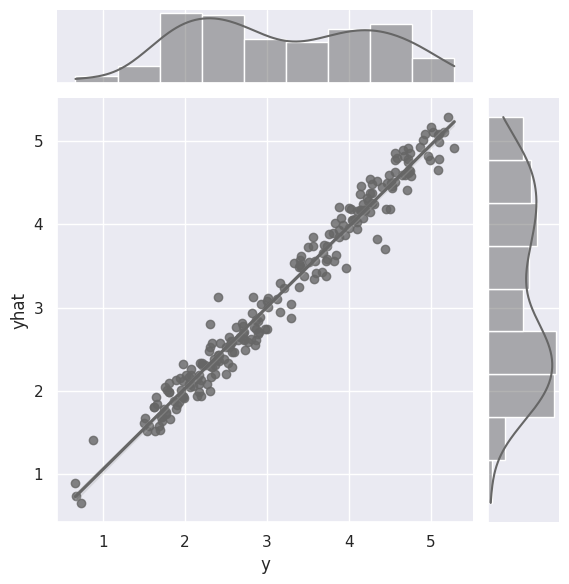

In [44]:
# Evaluate MAE, MSE, R2 on train data
train = model.predict(train_df)
train["y"] = train_df["y"].values
evaluate(train)

MAE = 0.2147
MSE = 0.0683
R2 = 0.8457


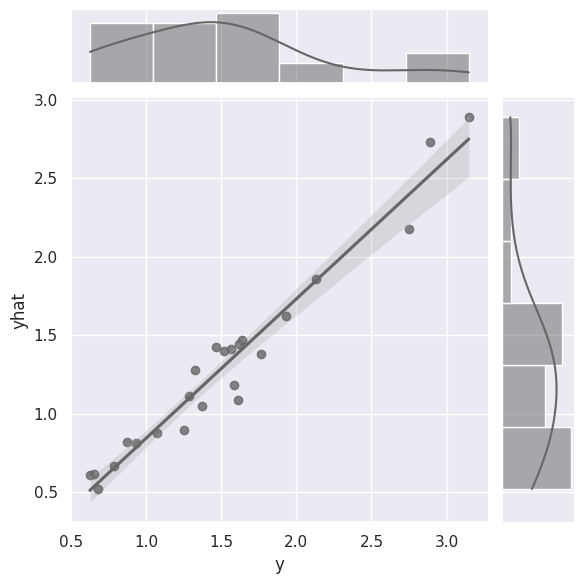

In [45]:
# Evaluate MAE, MSE, R2 on test data
test = model.predict(test_df)
test["y"] = test_df["y"].values
evaluate(test)

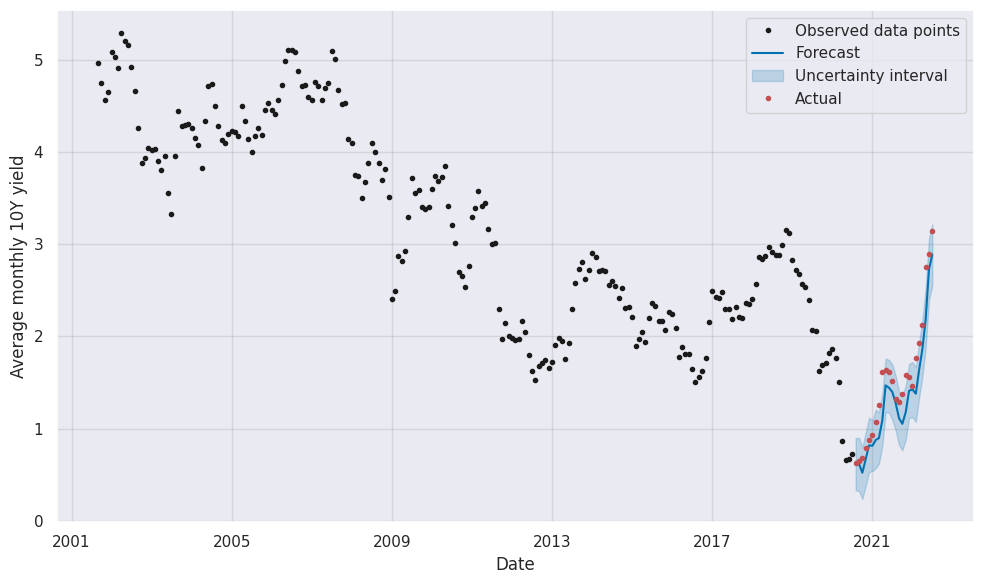

In [46]:
fig = model.plot(test)
plt.plot(test["ds"], test["y"], label="Actual", marker="o", markersize=3, color="r", linestyle="")
plt.xlabel("Date")
plt.ylabel("Average monthly 10Y yield")
plt.legend()
plt.show()

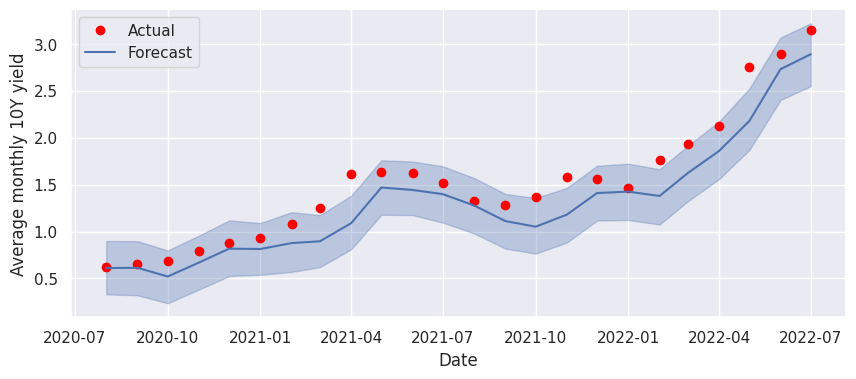

In [47]:
# Plot the forecast
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(test["ds"], test["y"], label="Actual", marker="o", color="red", linestyle="")
plt.plot(test["ds"], test["yhat"], label="Forecast", color="b")
ax.fill_between(test["ds"], test["yhat_lower"], test["yhat_upper"], color="b", alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Average monthly 10Y yield")
plt.legend()
plt.grid(True)

> From the components, average yield trends downwards, while contributions from regressors increase

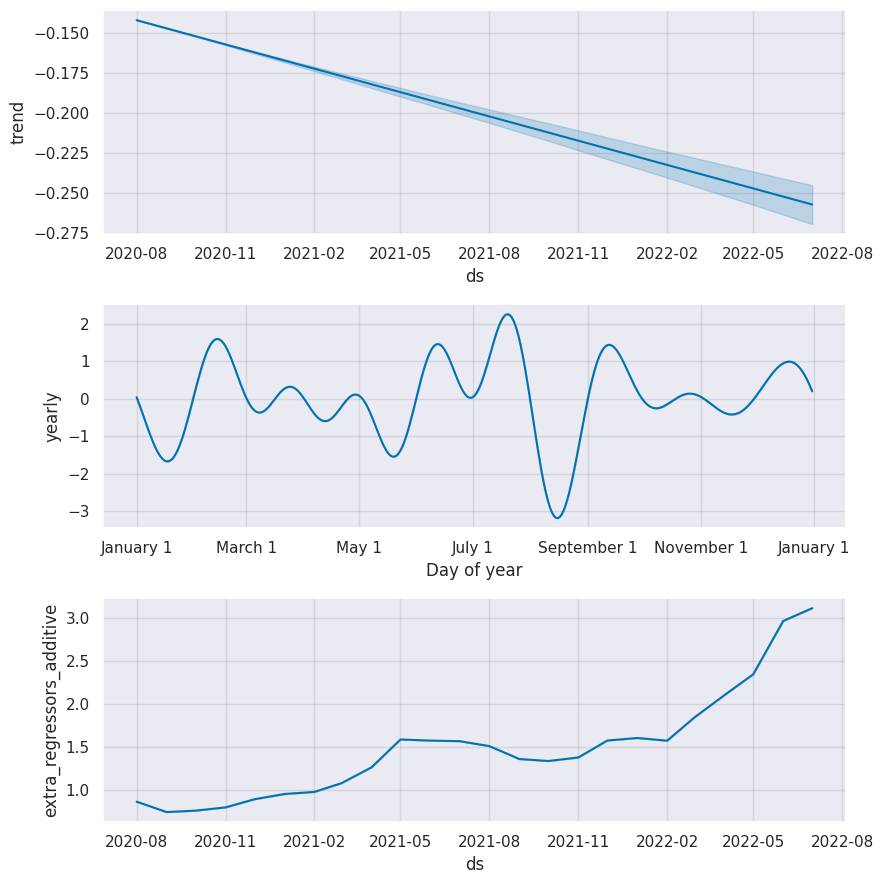

In [40]:
# Plot components
f = model.plot_components(test)